In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')
import anuga
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = './'


# Polygon defining broad area of interest
bounding_polygon = anuga.read_polygon(os.path.join(data_dir,'polygons/extent.csv'))

# Polygon defining particular area of interest
bantian_polygon = anuga.read_polygon(os.path.join(data_dir,'polygons/bantian.csv'))

# Elevation Data
topography_file = os.path.join(data_dir,'toasc/dem.asc')

In [3]:
# Resolution for most of the mesh
base_resolution = 1500.0  # m^2

# Resolution in particular area of interest
bantian_resolution = 900.0 # m^2

interior_regions = [[bantian_polygon, bantian_resolution]]

In [4]:
domain = anuga.create_domain_from_regions(
            bounding_polygon,
            boundary_tags={'south': [0],
                           'east':  [1],
                           'north':    [2],
                           'west':   [3],
                          'exterior': [4]},
            maximum_triangle_area=base_resolution,
            interior_regions=interior_regions)


domain.set_name('bantian_test') # Name of sww file

Figure files for each frame will be stored in _plot


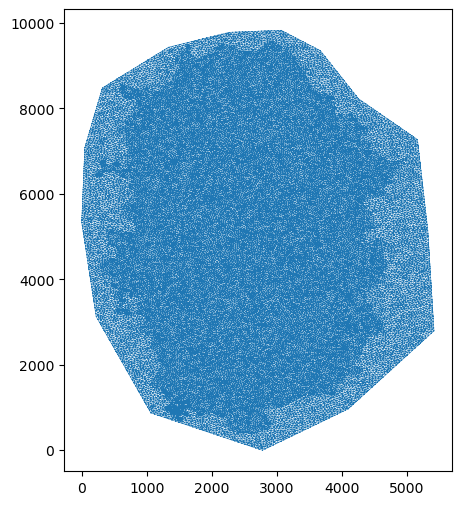

In [5]:
dplotter = anuga.Domain_plotter(domain)
plt.figure(figsize=(5, 6))
plt.triplot(dplotter.triang, linewidth = 0.4);

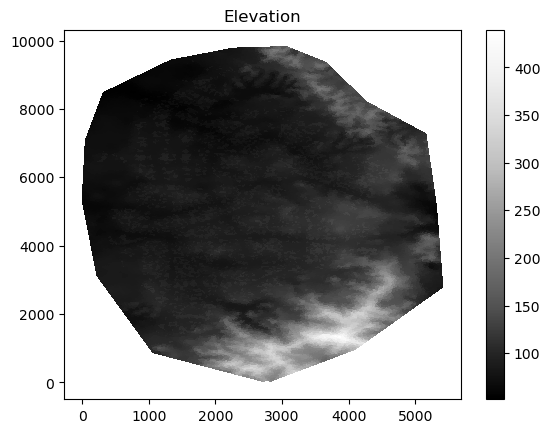

In [6]:
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', 0.01, location='centroids')                        # Constant friction
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed

plt.tripcolor(dplotter.triang,
              facecolors = dplotter.elev,
              cmap='Greys_r')
plt.colorbar();
plt.title("Elevation");

In [7]:
# Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)

domain.set_boundary({'south':   Bt,
                     'east':    Bt, # outflow
                     'north':   Bt, # outflow
                     'west':    Bt,
                    'exterior':  Bt})

SWMM模型的运行和结果处理

In [8]:
from pyswmm import Simulation, Nodes
import numpy as np
import re

def parse_coordinates(inp_file):
    """ 从 SWMM .inp 文件中解析节点坐标 """
    coords = {}
    with open(inp_file, 'r') as file:
        read_coords = False
        for line in file:
            if line.startswith('[COORDINATES]'):
                read_coords = True
                continue
            if read_coords:
                if line.startswith('['):  # 结束坐标部分
                    break
                parts = line.split()
                if len(parts) >= 3:
                    try:
                        node_id, x, y = parts[0], float(parts[1]), float(parts[2])
                        coords[node_id] = (x, y)
                    except ValueError:
                        continue
    return coords

def run_simulation_and_collect_data(inp_file):
    """ 运行模拟并收集节点的溢流数据 """
    node_coords = parse_coordinates(inp_file)
    #模拟时间6小时，时间步长为10分钟
    time_steps = np.arange(0, 135 + 1, 10) * 60  # 转换为秒
    node_data = {node_id: {'coords': coords, 'overflows': [0]*len(time_steps)} for node_id, coords in node_coords.items()}  # 初始化溢流数组以匹配时间步数

    # 运行模拟并收集数据
    with Simulation(inp_file) as sim:
        time_step_index = 0  # 跟踪当前时间步长的索引
        for step in sim:
            current_time = sim.current_time
            elapsed_time = (current_time - sim.start_time).total_seconds()
            # 更新数据直到当前步骤的时间超过下一个预定时间步长
            while time_step_index < len(time_steps) and elapsed_time >= time_steps[time_step_index]:
                for node_id in node_coords.keys():
                    swmm_node = Nodes(sim)[node_id]
                    # 更新溢流数据
                    node_data[node_id]['overflows'][time_step_index] = swmm_node.flooding
                time_step_index += 1

    # 筛选出有溢流记录的节点
    overflow_nodes = {node_id: data for node_id, data in node_data.items() if any(data['overflows'])}

    return overflow_nodes, time_steps.tolist(), node_coords


def write_results_to_file(overflow_results, node_coords, time_steps, file_name):
    """ 将结果写入到文本文件中 """
    with open(file_name, 'w') as file:
        file.write("Time Steps (in seconds): {}\n".format(time_steps))
        file.write("Overflow Nodes:\n")
        for node_id, data in overflow_results.items():
            file.write("{}: Overflows: {}\n".format(node_id, data['overflows']))

        if overflow_results:
            file.write("\nNode Coordinates:\n")
            for node_id in overflow_results.keys():
                file.write("{}: Coordinates: {}\n".format(node_id, node_coords[node_id]))

# 调用函数并传入你的 SWMM 模型文件路径
inp_file = './swmm_folder/swmm.inp'  # 替换为您的模型文件路径
overflow_results, time_steps, node_coords = run_simulation_and_collect_data(inp_file)

# 将结果写入文件
if overflow_results:
    file_name = 'overflow_results.txt'
    write_results_to_file(overflow_results, node_coords, time_steps, file_name)
    print(f"Results have been written to {file_name}")
else:
    print("No overflows occurred.")

Results have been written to overflow_results.txt


读取SWMM的结果

In [9]:
file_path = './overflow_results.txt'

# 初始化字典来存储溢流数据和坐标
overflow_nodes = {}

with open(file_path, 'r') as file:
    lines = file.readlines()

# 解析时间步长
time_steps_line = next(line for line in lines if line.startswith("Time Steps"))
time_steps = [int(t) for t in time_steps_line.split(': ')[1].strip().strip('[]').split(', ')]

# 解析溢流节点数据
overflow_section = False
for line in lines:
    if line.startswith("Overflow Nodes:"):
        overflow_section = True
        continue
    if line.startswith("Node Coordinates:"):
        overflow_section = False
        continue
    if overflow_section and "Overflows:" in line:
        parts = line.split(': Overflows: ')
        node_id = parts[0].strip()
        values = parts[1].strip().strip('[]').split(', ')
        overflow_values = [float(v) for v in values]
        # 确保溢流数组长度与时间步长数组长度相同
        if len(overflow_values) < len(time_steps):
            overflow_values.extend([0.0] * (len(time_steps) - len(overflow_values)))
        overflow_nodes[node_id] = {'overflows': overflow_values}

# 解析节点坐标数据
coords_section = False
for line in lines:
    if line.startswith("Node Coordinates:"):
        coords_section = True
        continue
    if coords_section:
        parts = line.split(': Coordinates: ')
        if len(parts) == 2:
            node_id = parts[0].strip()
            coords = tuple(map(float, parts[1].strip().strip('()').split(', ')))
            if node_id in overflow_nodes:
                overflow_nodes[node_id]['coords'] = coords

time_steps, overflow_nodes  # 返回时间步长和溢流节点数据



([0,
  600,
  1200,
  1800,
  2400,
  3000,
  3600,
  4200,
  4800,
  5400,
  6000,
  6600,
  7200,
  7800],
 {'XZnode467': {'overflows': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    5.590205903684642,
    9.717080428634654,
    9.716821766919676,
    8.575412923375813,
    6.953370034003764,
    5.7081225220604965,
    4.662512540332719,
    3.798881342333831,
    1.904869704107234],
   'coords': (505388.946, 2506205.856)},
  'XZnode468': {'overflows': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.716123618812095,
    0.7161228048704753,
    0.7161231157780311,
    0.7161231948323366,
    0.7161229950518799,
    0.716123132535133,
    0.7161230774667241,
    0.7161230767543009,
    0.7161230940064219],
   'coords': (505385.74, 2506234.187)},
  'XZnode469': {'overflows': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    2.029714398034455,
    2.4660801103185364,
    2.0045803839165655,
    1.5885930032007791,
    0.9540089323674086,
    0.3714378374601666,
    0.0,
    0.0,
    0.0],
  

单项耦合

Simulation progress: 0.00%


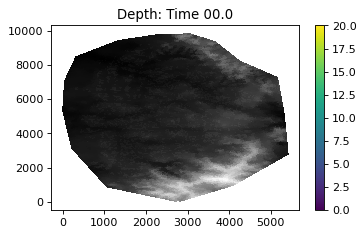

Time = 0.0000 (sec), steps=0 (63s)
Simulation progress: 7.69%


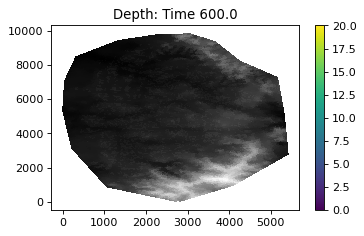

Time = 600.0000 (sec), delta t = 1000.00000000 (s), steps=1 (12s)
Simulation progress: 15.38%


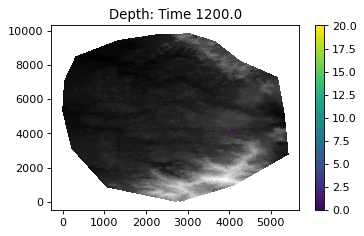

Time = 1200.0000 (sec), delta t = 1000.00000000 (s), steps=1 (13s)
Simulation progress: 23.08%


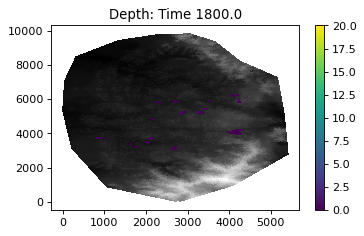

Time = 1800.0000 (sec), delta t in [2.84185463, 5.40438599] (s), steps=141 (27s)
Simulation progress: 30.77%


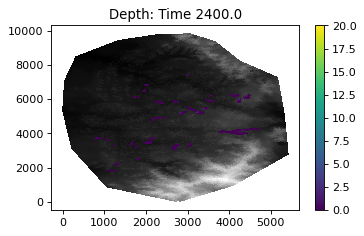

Time = 2400.0000 (sec), delta t in [2.36568166, 3.63116467] (s), steps=229 (62s)
Simulation progress: 38.46%


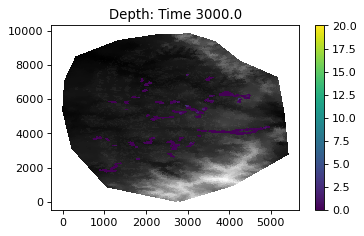

Time = 3000.0000 (sec), delta t in [1.77831379, 2.36584806] (s), steps=297 (57s)
Simulation progress: 46.15%


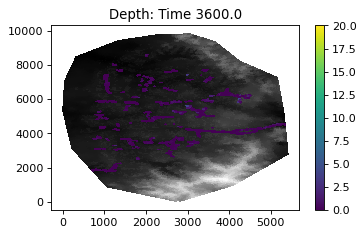

Time = 3600.0000 (sec), delta t in [1.25150940, 1.77815588] (s), steps=414 (88s)
Simulation progress: 53.85%


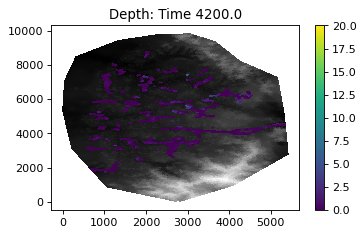

Time = 4200.0000 (sec), delta t in [1.04559796, 1.25142219] (s), steps=534 (123s)
Simulation progress: 61.54%


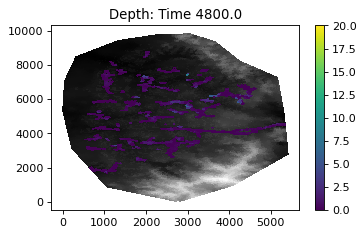

Time = 4800.0000 (sec), delta t in [1.01361041, 1.05660286] (s), steps=584 (146s)
Simulation progress: 69.23%


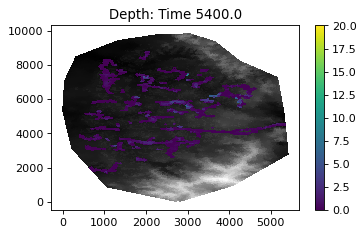

Time = 5400.0000 (sec), delta t in [0.98656544, 1.01360597] (s), steps=603 (162s)
Simulation progress: 76.92%


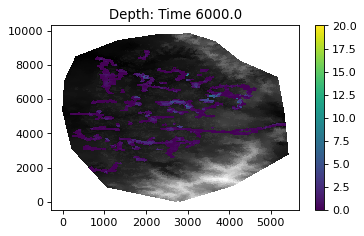

Time = 6000.0000 (sec), delta t in [0.93392920, 0.98656513] (s), steps=628 (223s)
Simulation progress: 84.62%


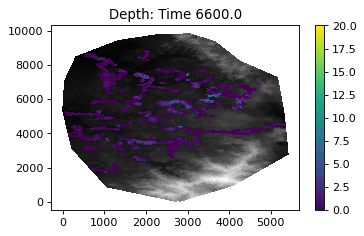

Time = 6600.0000 (sec), delta t in [0.87127683, 0.93384594] (s), steps=675 (254s)
Simulation progress: 92.31%


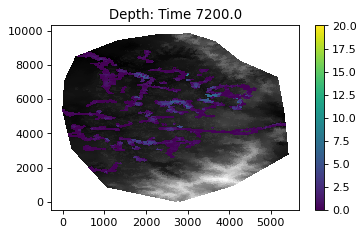

Time = 7200.0000 (sec), delta t in [0.87118909, 0.87127609] (s), steps=689 (292s)
Simulation progress: 100.00%


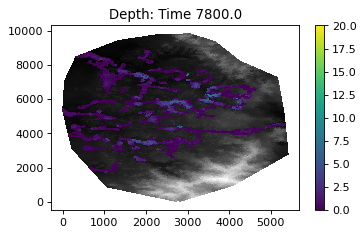

Time = 7800.0000 (sec), delta t in [0.87118909, 0.87118909] (s), steps=689 (286s)


In [10]:
import numpy as np
import anuga

def get_Q_value(time, values, t):
    return np.interp(t, time, values, left=values[0], right=values[-1])

# 使用文件中的时间步长
time = time_steps

# 动态创建溢流数据列表和坐标列表
value_lists = [data['overflows'] for data in overflow_nodes.values()]
node_coords = [data['coords'] for data in overflow_nodes.values()]

# 模拟循环
for t in domain.evolve(yieldstep=600, finaltime=7800):
    Q_values = (get_Q_value(time, values, t) for values in value_lists)
    progress = (domain.get_time() / 7800) * 100
    print(f"Simulation progress: {progress:.2f}%")
    
    # 创建溢流操作列表
    over_flows = [
        anuga.Inlet_operator(domain, region=anuga.Region(domain, center=coords, radius=40), Q=Q)
        for coords, Q in zip(node_coords, Q_values)
    ]
    
    # 溢流调整
    # for over_flow in over_flows:
    #     if domain.get_time() >= 10800 and over_flow.get_Q() == 0.0:
    #         over_flow.set_Q(-0.8)

    dplotter.save_depth_frame(vmin=0.0, vmax=1.0)
    dplotter.plot_depth_frame()
    domain.print_timestepping_statistics()


In [11]:
dplotter.make_depth_animation()

输出结果

In [7]:
# 指定 SWW 文件名
sww_file = 'bantian100.sww'

# 指定 DEM 输出的基本文件名
basename_out = './velocity/flooding100'

# 遍历模拟的每个计算时刻
for t in range(13):
    # 生成 DEM 文件
    current_dem_file = f'{basename_out}_{t:05d}.asc'  # 使用时间步数作为文件名的一部分，方便区分不同时刻的 DEM
    
    # 将当前时间步的水深结果转换为 DEM 文件
    anuga.sww2dem(sww_file, current_dem_file, quantity='xmomentum', reduction=t,cellsize=30)

In [11]:
import netCDF4 as nc

def list_variables(sww_file):
    ds = nc.Dataset(sww_file)
    print("Variables in the file:")
    for var in ds.variables:
        print(var)

# 调用函数列出文件中的变量
list_variables('D:/anuga_test/深圳模拟/bantian05.sww')

Variables in the file:
x
y
volumes
elevation
elevation_range
friction
friction_range
elevation_c
friction_c
stage
stage_range
xmomentum
xmomentum_range
ymomentum
ymomentum_range
stage_c
xmomentum_c
ymomentum_c
time


In [ ]:
# 指定 SWW 文件名
sww_file = 'bantian2.sww'

# 指定 DEM 输出的基本文件名
basename_out = './output/buildings_result'  # 输出文件的基本名称，没有时间步数部分

# 遍历模拟的每个计算时刻
for t in range(8):
    # 生成 DEM 文件名
    current_dem_file = f'{basename_out}_{t:05d}.asc'  # 使用时间步数作为文件名的一部分，方便区分不同时刻的 DEM
    
    # 将当前时间步的水深结果转换为 DEM 文件
    anuga.sww2dem(sww_file, current_dem_file, quantity='depth', reduction=t,cellsize=30)

In [11]:
import netCDF4 as nc
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon

def sww_to_shp(sww_file, shp_file):
    # 打开 sww 文件
    ds = nc.Dataset(sww_file)

    # 读取节点坐标
    x = ds.variables['x'][:]
    y = ds.variables['y'][:]
    nodes = np.column_stack((x, y))  # 将 x 和 y 坐标合并

    # 读取元素（节点索引）
    elements = ds.variables['volumes'][:]

    # 创建多边形（假设网格是由三角形构成）
    polygons = [Polygon(nodes[element]) for element in elements]

    # 创建 GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': polygons})

    # 导出为 Shapefile
    gdf.to_file(shp_file)

# 调用函数进行转换
sww_to_shp('bantian100.sww', 'E:\\python_project\\anuga_test\\深圳模拟\\mesh.shp')